<a href="https://colab.research.google.com/github/chelynl/darts_python/blob/main/Time_Series_Using_Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will explore various time series model using the Darts library including:
- Exponential Smoothing Models
- ARIMA models
- ARIMAX models

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# !pip install u8darts[all]
from darts import TimeSeries, ModelMode
from darts.models import ExponentialSmoothing, AutoARIMA
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, extract_trend_and_seasonality
from darts.utils.timeseries_generation import linear_timeseries, gaussian_timeseries

Import Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
oz_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/Ozone_Raleigh2.csv')
co_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/CO_Raleigh.csv')
no_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/NO_Raleigh.csv')
weather_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/Raleigh_weather.csv')
so2_df = pd.read_csv('/content/drive/MyDrive/NCSU MSA/Fall Term II/Time Series/Data/SO2_Raleigh.csv')

Start exploring data

In [6]:
# # See preview of each df
# oz_df.head()
# co_df.head()
# no_df.head()
# so2_df.head()

# See datacol types
oz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2283 entries, 0 to 2282
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  2283 non-null   object 
 1   Source                                2283 non-null   object 
 2   Site ID                               2283 non-null   int64  
 3   POC                                   2283 non-null   int64  
 4   Daily Max 8-hour Ozone Concentration  2283 non-null   float64
 5   UNITS                                 2283 non-null   object 
 6   DAILY_AQI_VALUE                       2283 non-null   int64  
 7   Site Name                             2283 non-null   object 
 8   DAILY_OBS_COUNT                       2283 non-null   int64  
 9   PERCENT_COMPLETE                      2283 non-null   int64  
 10  AQS_PARAMETER_CODE                    2283 non-null   int64  
 11  AQS_PARAMETER_DES

In [7]:
# Rename col names to make them easier to handle
oz_df.rename(columns={'Daily Max 8-hour Ozone Concentration':'daily_max_oz'}, inplace=True)
co_df.rename(columns={'Daily Max 8-hour CO Concentration':'daily_max_co'}, inplace=True)
no_df.rename(columns={'Daily Max 1-hour NO2 Concentration':'daily_max_no'}, inplace=True)
so2_df.rename(columns={'Daily Max 1-hour SO2 Concentration':'daily_max_so'}, inplace=True)

# Convert Date cols to datetime 
oz_df['Date'] = pd.to_datetime(oz_df['Date'])
co_df['Date'] = pd.to_datetime(co_df['Date'])
no_df['Date'] = pd.to_datetime(no_df['Date'])
so2_df['Date'] = pd.to_datetime(so2_df['Date'])

In [8]:
print('Start Date: ', oz_df['Date'].iloc[0])
print('End Date: ', oz_df['Date'].iloc[-1])

# Preview ozone df
oz_df.head()

Start Date:  2014-01-01 00:00:00
End Date:  2020-05-31 00:00:00


,Date,Source,Site ID,POC,daily_max_oz,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,2014-01-01,AQS,371830014,1,0.026,ppm,24,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
1,2014-01-02,AQS,371830014,1,0.017,ppm,16,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
2,2014-01-03,AQS,371830014,1,0.035,ppm,32,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
3,2014-01-04,AQS,371830014,1,0.030,ppm,28,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167
4,2014-01-05,AQS,371830014,1,0.023,ppm,21,Millbrook School,17,100,44201,Ozone,39580,"Raleigh, NC",37,North Carolina,183,Wake,35.856111,-78.574167


In [9]:
# Identify missing values with NaN and make ts objects for each df
oz_nulls_ts = TimeSeries.from_dataframe(oz_df, time_col='Date', value_cols='daily_max_oz', freq='D', fill_missing_dates=True)
co_nulls_ts = TimeSeries.from_dataframe(co_df, 'Date', 'daily_max_co', freq='D', fill_missing_dates=True)
no_nulls_ts = TimeSeries.from_dataframe(no_df, 'Date', 'daily_max_no', freq='D', fill_missing_dates=True)
so2_nulls_ts = TimeSeries.from_dataframe(so2_df, 'Date', 'daily_max_so', freq='D', fill_missing_dates=True)

# Impute missing values and re-assign ts objects
filler = MissingValuesFiller()
oz_imputed_ts = filler.transform(oz_nulls_ts, method='quadratic') # use pd.interpolate() args when calling transform(), method='linear' is default
co_imputed_ts = filler.transform(co_nulls_ts, method='quadratic')
no_imputed_ts = filler.transform(no_nulls_ts, method='quadratic')
so2_imputed_ts = filler.transform(so2_nulls_ts, method='quadratic')

We will first roll up the data to the monthly level and try fitting an exponentia smoothing model.

In [10]:
# Set Date as index; needed for rolling up monthly
oz_df.set_index('Date', inplace=True)

# Monthly ozone
monthly_oz = oz_df.resample(rule='M').mean()

# Change col name from daily to monthly oz conc
monthly_oz.rename(columns={'daily_max_oz': 'monthly_max_oz'}, inplace=True)

# Reset index to use Date col for creating ts object
monthly_oz.reset_index(inplace=True)

monthly_oz.head()

,Date,Site ID,POC,monthly_max_oz,DAILY_AQI_VALUE,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,CBSA_CODE,STATE_CODE,COUNTY_CODE,SITE_LATITUDE,SITE_LONGITUDE
0,2014-01-31,371830014.0,1.0,0.028552,26.448276,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
1,2014-02-28,371830014.0,1.0,0.034607,32.107143,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
2,2014-03-31,371830014.0,1.0,0.042355,39.741935,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
3,2014-04-30,371830014.0,1.0,0.048233,47.500000,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167
4,2014-05-31,371830014.0,1.0,0.049419,47.870968,17.0,100.0,44201.0,39580.0,37.0,183.0,35.856111,-78.574167


In [11]:
# Create monthly ts object
monthly_ts = TimeSeries.from_dataframe(monthly_oz, time_col='Date', value_cols='monthly_max_oz', freq='M')

# Get training+validation and test sets
train_valid, test = monthly_ts.split_before(pd.Timestamp('2020-01-31'))
# Split training+validation into respective parts
train, valid = train_valid.split_before(pd.Timestamp('2019-01-31'))

Text(0.5, 1.0, 'Time Plot of Raw Training')

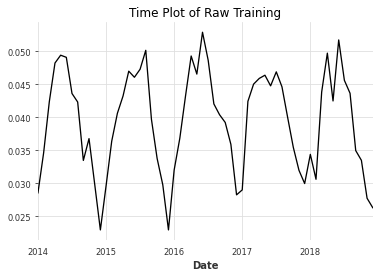

In [12]:
# Visualize the plot --> additive seasonality since variance is fairly constant
train.plot()
plt.title('Time Plot of Raw Training')

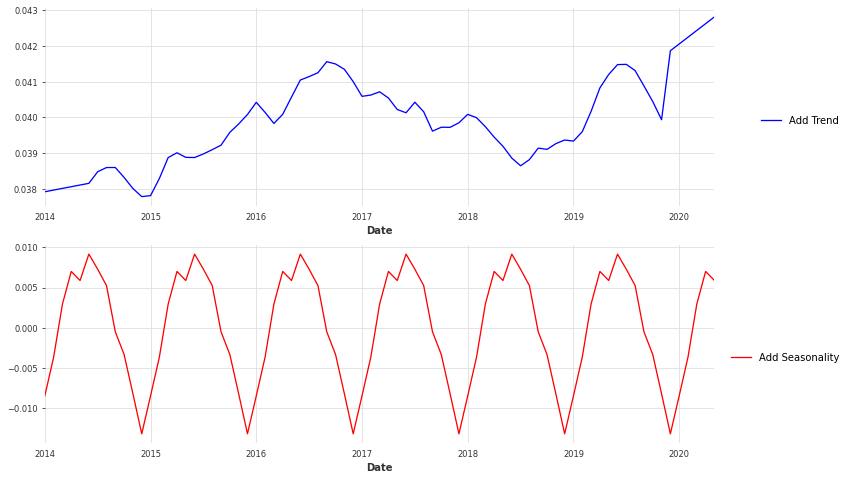

In [14]:
# Create enums for additive models since
add = ModelMode('additive')

# Extract and assign vars to trend and seasonality
add_trend = extract_trend_and_seasonality(monthly_ts, freq=12, model=add)[0]
add_seasonal = extract_trend_and_seasonality(monthly_ts, freq=12, model=add)[1]

# Plot trends and seasonality
plt.figure(figsize=(12,8))
plt.subplot(211)
add_trend.plot(label='Add Trend', color="blue")
plt.legend(loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.5))
plt.subplot(212)
add_seasonal.plot(label='Add Seasonality', color='red')
plt.legend(loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.5))

Although we can see a slight upwards pattern in the trend component, the scale of the vertical axis is so small that we can conclude trend to be negligible. The seasonality component has constant variance in its oscillating pattern, which implies additive seasonality.

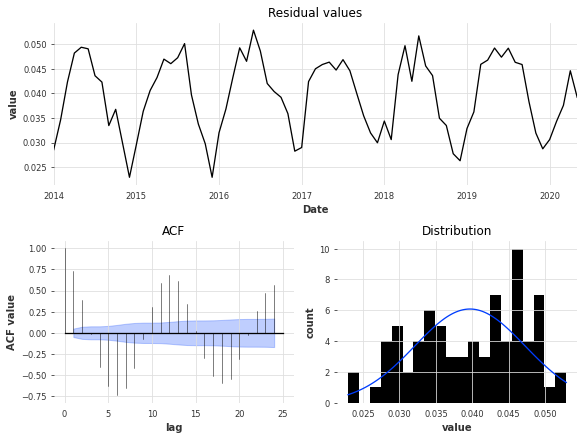

In [17]:
# See residuals of monthly ozone ts
plot_residuals_analysis(monthly_ts)

Text(0.5, 1.0, 'ESM: Predicted vs. Actual')

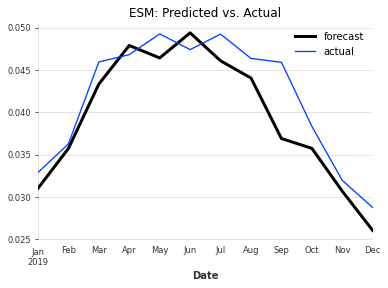

In [18]:
# Initalize Exponential Smoothing model; additive by default
esm = ExponentialSmoothing()

# Fit model to training data
esm.fit(train)

# Get validation predictions
valid_pred = esm.predict(len(valid))

valid_pred.plot(label='forecast', lw=3)
valid.plot(label='actual')
plt.legend()
plt.title('ESM: Predicted vs. Actual')

### Confirm whether we have white noise using methods below:
- <b>Autocorrelation Plots</b> 
  - check for correlation between lagged variables
- <b>Ljung-Box test</b>
  - null hypothesis: series has no autocorrelation 
  - alt hypothesis: autocorrelation exists b/w signal and lagged version
  - `Box-Pierce test` is simplified version
- <b>Line plot</b>
  - check for mean about 0, constant variance, no relationship between lagged variables)
- <b>Summary statistics</b>
  - check mean/variance of whole series against mean/variance of useful time-blocks in the series (e.g. days, months, or years)


In [33]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.stats.diagnostic as diag # diagnostic tests for WN

# Perform both Ljung-Box and Box-Pierce tests up to 20 lags
diag.acorr_ljungbox(monthly_oz['monthly_max_oz'], lags=[20], boxpierce=True)

(array([446.32717043]),
 array([4.75254922e-82]),
 array([376.90418639]),
 array([1.24300809e-67]))

The p-values for both the Ljung-Box and Box-Pierce tests were extremely small (rejecting null) and thus we can conclude that there is NO white noise. We must try another modeling technique to capture all the signal.

***

Next, we will try ARIMA forecasting and use the time-series data at the daily level.

In [27]:
""" Test set = last 14 days 
  Validation set = 28 days 
  Training set = all days prior """

# Get training+validation and test sets
train_valid, test = oz_imputed_ts.split_after(pd.Timestamp('2020-05-17')) # test set is the last 14 days

# Split Training+Validation into respective parts
train, valid = train_valid.split_before(pd.Timestamp('2020-04-20')) # validation set is last 28 days from combined data

Text(0.5, 1.0, 'Time Plot of Raw Training')

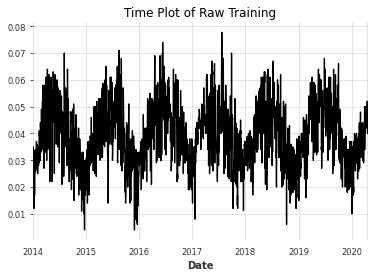

In [30]:
# Visualize the plot --> still additive seasonality
train.plot()
plt.title('Time Plot of Raw Training')

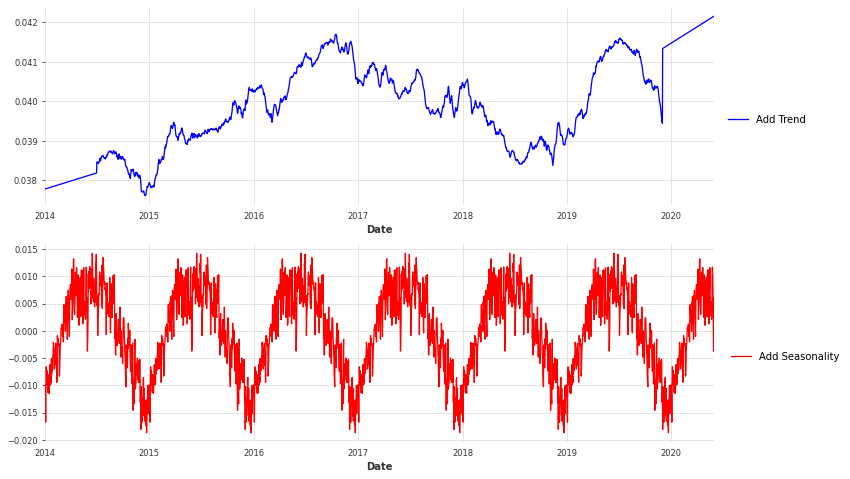

In [31]:
# Create enums for additive models since
add = ModelMode('additive')

# Extract and assign vars to trend and seasonality
add_trend = extract_trend_and_seasonality(oz_imputed_ts, freq=365, model=add)[0]
add_seasonal = extract_trend_and_seasonality(oz_imputed_ts, freq=365, model=add)[1]

# Plot trends and seasonality
plt.figure(figsize=(12,8))
plt.subplot(211)
add_trend.plot(label='Add Trend', color="blue")
plt.legend(loc='best', bbox_to_anchor=(0.65, 0., 0.5, 0.5))
plt.subplot(212)
add_seasonal.plot(label='Add Seasonality', color='red')
plt.legend(loc='best', bbox_to_anchor=(0.7, 0., 0.5, 0.5))

Seasonality is apparent and we need to take care of its functional form first (before considering trend or autocorrelation) because it is possible that a trend can disappear after taking care of its seasonal component.

***

### Three methods for capturing seasonality signal
- <b>Deterministic pattern</b>
  - Fit dummy variables model (better for shorter length seasons-- good for yearly, quarterly, monthly data)
  - Fit sin/cosine model aka Fourier Transformation (better for longer length seasons-- good for hourly, daily data)
- <b>Stochastic pattern</b>
  - Take seasonal differences

We will not be exploring external regressors just yet (ARIMAX to come later).

We will first consider deterministic patterns over stochastic because taking differences increases confidence intervals and fitting a regression may be the better choice. 

After accounting for deterministic seasonality with a regression (using either dummy variables or fourier), we can look for seasonal dependence (correlation structure) by checking whether the residuals are stationary.

If residuals are not stationary, you may need to take seasonal differences (stochastic pattern). 

Goal: get stationary series (residuals) in order to model with ARIMA!


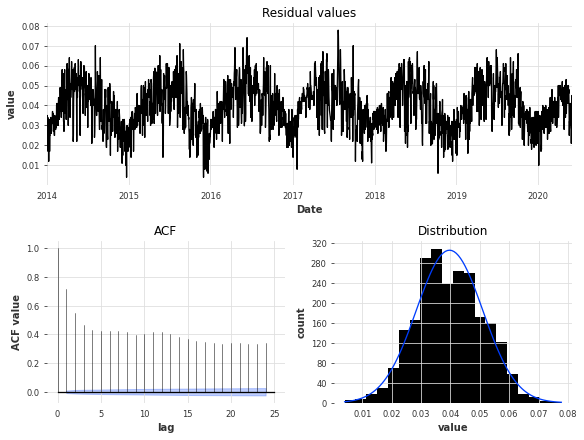

In [32]:
# See residuals
plot_residuals_analysis(oz_imputed_ts)